In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_csv("archive(3)/US_Accidents_March23.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

In [3]:


# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 52 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   Severity               int64         
 3   Start_Time             datetime64[ns]
 4   End_Time               datetime64[ns]
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   End_Lat                float64       
 8   End_Lng                float64       
 9   Distance(mi)           float64       
 10  Description            object        
 11  Street                 object        
 12  City                   object        
 13  County                 object        
 14  State                  object        
 15  Zipcode                object        
 16  Country                object        
 17  Timezone               object        
 18  Airport_Code          

In [4]:


# Check if there is any negative time_duration values
df[td][df[td]<=0]



Series([], Name: Time_Duration(min), dtype: float64)

In [5]:


# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 6985228 entries, 0 to 7728393
Data columns (total 52 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   Severity               int64         
 3   Start_Time             datetime64[ns]
 4   End_Time               datetime64[ns]
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   End_Lat                float64       
 8   End_Lng                float64       
 9   Distance(mi)           float64       
 10  Description            object        
 11  Street                 object        
 12  City                   object        
 13  County                 object        
 14  State                  object        
 15  Zipcode                object        
 16  Country                object        
 17  Timezone               object        
 18  Airport_Code           obje

In [6]:


# Double check to make sure no more negative td
df[td][df[td]<=0]



Series([], Name: Time_Duration(min), dtype: float64)

In [7]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6985228 entries, 0 to 7728393
Data columns (total 52 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   Severity               float64       
 3   Start_Time             datetime64[ns]
 4   End_Time               datetime64[ns]
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   End_Lat                float64       
 8   End_Lng                float64       
 9   Distance(mi)           float64       
 10  Description            object        
 11  Street                 object        
 12  City                   object        
 13  County                 object        
 14  State                  object        
 15  Zipcode                object        
 16  Country                object        
 17  Timezone               object        
 18  Airport_Code           obje

In [8]:


# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df[td].max(),round(df[td].max()/60), round(df[td].max()/60/24), df[td].min()))



Max time to clear an accident: 39753.0 minutes or 663 hours or 28 days; Min to clear an accident td: 1.0 minutes.


In [9]:


# Set the list of features to include in Machine Learning
feature_lst=['Source','Severity','Start_Lng','Start_Lat','Distance(mi)','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']



In [10]:
# Select the dataset to include only the selected features
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6985228 entries, 0 to 7728393
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Source              object 
 1   Severity            float64
 2   Start_Lng           float64
 3   Start_Lat           float64
 4   Distance(mi)        float64
 5   City                object 
 6   County              object 
 7   State               object 
 8   Timezone            object 
 9   Temperature(F)      float64
 10  Humidity(%)         float64
 11  Pressure(in)        float64
 12  Visibility(mi)      float64
 13  Wind_Direction      object 
 14  Weather_Condition   object 
 15  Amenity             object 
 16  Bump                object 
 17  Crossing            object 
 18  Give_Way            object 
 19  Junction            object 
 20  No_Exit             object 
 21  Railway             object 
 22  Roundabout          object 
 23  Station             object 
 24  Stop                object 
 

In [11]:
df_sel.isnull().mean()

Source                0.000686
Severity              0.000686
Start_Lng             0.000686
Start_Lat             0.000686
Distance(mi)          0.000686
City                  0.000718
County                0.000686
State                 0.000686
Timezone              0.001657
Temperature(F)        0.021585
Humidity(%)           0.022910
Pressure(in)          0.018607
Visibility(mi)        0.023304
Wind_Direction        0.022628
Weather_Condition     0.022926
Amenity               0.000686
Bump                  0.000686
Crossing              0.000686
Give_Way              0.000686
Junction              0.000686
No_Exit               0.000686
Railway               0.000686
Roundabout            0.000686
Station               0.000686
Stop                  0.000686
Traffic_Calming       0.000686
Traffic_Signal        0.000686
Turning_Loop          0.000686
Sunrise_Sunset        0.003182
Hour                  0.000686
Weekday               0.000686
Time_Duration(min)    0.000000
dtype: f

In [12]:


df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape



(6723955, 32)

In [13]:
# Set state
state='PA'

# Select the state of Pennsylvania
df_state=df_sel.loc[df_sel.State==state].copy()
df_state.drop('State',axis=1, inplace=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252149 entries, 197860 to 7727994
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Source              252149 non-null  object 
 1   Severity            252149 non-null  float64
 2   Start_Lng           252149 non-null  float64
 3   Start_Lat           252149 non-null  float64
 4   Distance(mi)        252149 non-null  float64
 5   City                252149 non-null  object 
 6   County              252149 non-null  object 
 7   Timezone            252149 non-null  object 
 8   Temperature(F)      252149 non-null  float64
 9   Humidity(%)         252149 non-null  float64
 10  Pressure(in)        252149 non-null  float64
 11  Visibility(mi)      252149 non-null  float64
 12  Wind_Direction      252149 non-null  object 
 13  Weather_Condition   252149 non-null  object 
 14  Amenity             252149 non-null  object 
 15  Bump                252149 non-nu

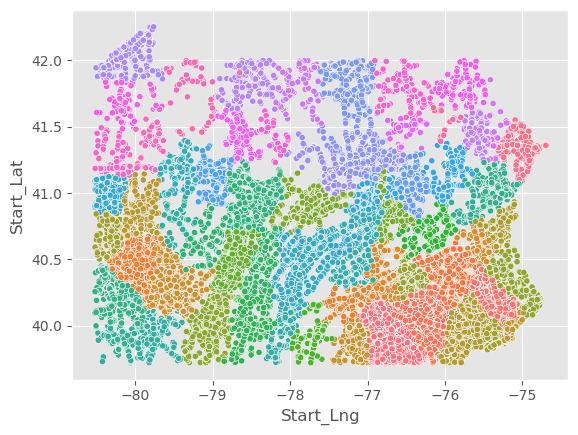

In [14]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20)
plt.show()

In [15]:


# Set county
county='Montgomery'

# Select the state of Pennsylvania
df_county=df_state.loc[df_state.County==county].copy()
df_county.drop('County',axis=1, inplace=True)
df_county.info()



<class 'pandas.core.frame.DataFrame'>
Index: 59372 entries, 228548 to 7727507
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              59372 non-null  object 
 1   Severity            59372 non-null  float64
 2   Start_Lng           59372 non-null  float64
 3   Start_Lat           59372 non-null  float64
 4   Distance(mi)        59372 non-null  float64
 5   City                59372 non-null  object 
 6   Timezone            59372 non-null  object 
 7   Temperature(F)      59372 non-null  float64
 8   Humidity(%)         59372 non-null  float64
 9   Pressure(in)        59372 non-null  float64
 10  Visibility(mi)      59372 non-null  float64
 11  Wind_Direction      59372 non-null  object 
 12  Weather_Condition   59372 non-null  object 
 13  Amenity             59372 non-null  object 
 14  Bump                59372 non-null  object 
 15  Crossing            59372 non-null  object 
 16  Gi

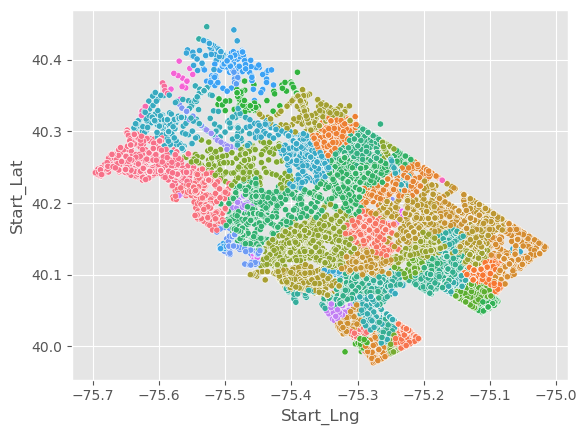

In [16]:
# Map of accidents, color code by city

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_county, hue='City', legend=False, s=20)
plt.show()

In [17]:


# Generate dummies for categorical data
df_county_dummy = pd.get_dummies(df_county,drop_first=True)

# Export data
# df_county_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

df_county_dummy.info()



<class 'pandas.core.frame.DataFrame'>
Index: 59372 entries, 228548 to 7727507
Columns: 176 entries, Severity to Weekday_Wed
dtypes: bool(166), float64(10)
memory usage: 14.4 MB


In [18]:


# Assign the data
df=df_county_dummy

# Set the target for the prediction
target='Severity'


# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)



In [19]:


# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]



In [25]:
# Logistic regression
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')  # Add multi_class='ovr'
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Get the accuracy score
acc = accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Logistic regression algorithm] accuracy_score: 0.936.


In [26]:
# Predict target values for the test data
y_pred_lr = lr.predict(X_test)
# Predict probabilities
probs = lr.predict_proba(X_test)

ROC Score:

Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        86
         2.0       0.94      0.99      0.97     10960
         3.0       0.73      0.33      0.45       714
         4.0       0.00      0.00      0.00       115

    accuracy                           0.94     11875
   macro avg       0.42      0.33      0.35     11875
weighted avg       0.91      0.94      0.92     11875


Confusion Matrix:


c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


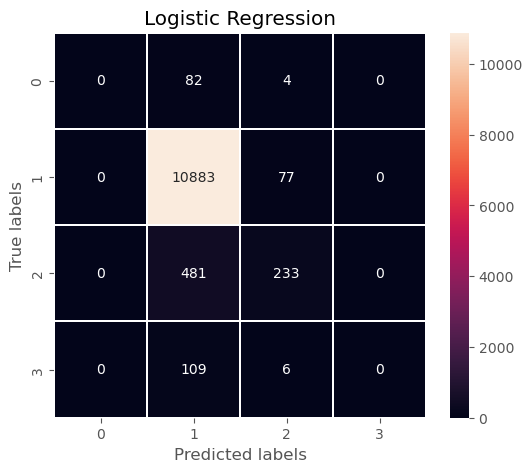

In [29]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, auc, roc_curve, roc_auc_score
# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
# print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_lr))

print('\nConfusion Matrix:')
#plot confusion matrix
confus_matrix_log = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize= (6,5))
ax= plt.subplot()
sns.heatmap(confus_matrix_log , annot=True, fmt='g', ax=ax, linewidth =0.2);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression'); 
# ax.xaxis.set_ticklabels(['Non-Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Non-Fraud', 'Fraud']);

In [32]:


from sklearn.model_selection import cross_val_score

# Instantiate the classifier model with n-neighbours of 2
knn = KNeighborsClassifier(n_neighbors=2)

# fitting the model
knn.fit(X_train, y_train)



KNeighborsClassifier(n_neighbors=2)

In [36]:
# Predict the classes on the test data
y_pred_knn = knn.predict(X_test.values)
# Predict probabilities
probs = knn.predict_proba(X_test.values)

c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


ROC Score:

Classification Report:
              precision    recall  f1-score   support

         1.0       0.30      0.43      0.35        86
         2.0       0.93      0.99      0.96     10960
         3.0       0.60      0.14      0.23       714
         4.0       0.30      0.05      0.09       115

    accuracy                           0.92     11875
   macro avg       0.53      0.40      0.41     11875
weighted avg       0.90      0.92      0.90     11875


Confusion Matrix:


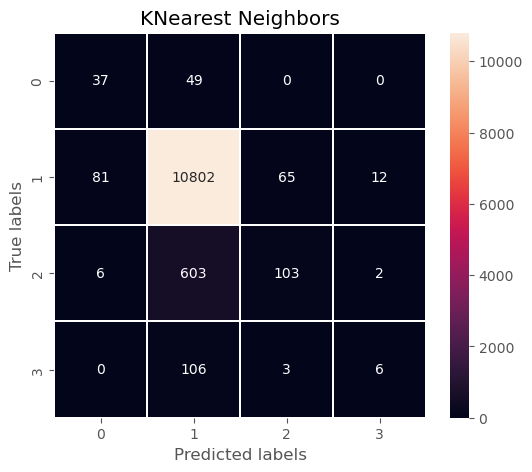

In [38]:
print('ROC Score:')
# print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_knn))

print('\nConfusion Matrix:')
#plot confusion matrix
confus_matrix_log = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize= (6,5))
ax= plt.subplot()
sns.heatmap(confus_matrix_log , annot=True, fmt='g', ax=ax, linewidth =0.2);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('KNearest Neighbors'); 

In [39]:


# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))



[Decision Tree -- entropy] accuracy_score: 0.951.
[Decision Tree -- gini] accuracy_score: 0.952.


In [40]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))

[Randon forest algorithm] accuracy_score: 0.959.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


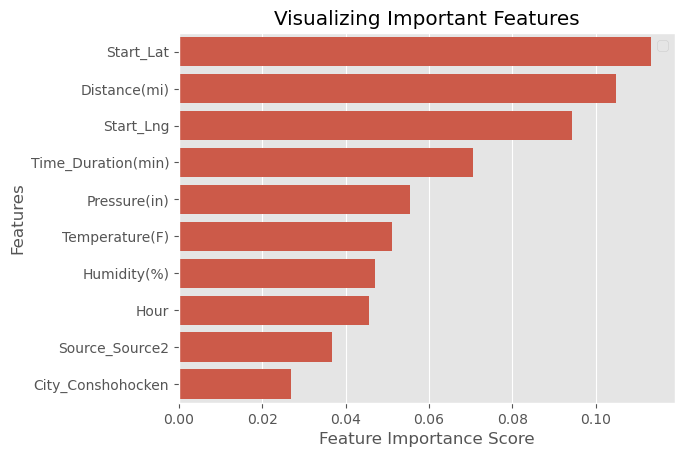

In [41]:


feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()



In [42]:


# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]



Start_Lat                 0.113380
Distance(mi)              0.105025
Start_Lng                 0.094467
Time_Duration(min)        0.070550
Pressure(in)              0.055574
Temperature(F)            0.051055
Humidity(%)               0.047179
Hour                      0.045566
Source_Source2            0.036679
City_Conshohocken         0.026962
Traffic_Signal_True       0.020942
Visibility(mi)            0.016113
City_King of Prussia      0.011807
City_Bala Cynwyd          0.011500
Crossing_True             0.010408
Weather_Condition_Fair    0.009733
Weekday_Tue               0.008651
Weekday_Thu               0.008596
Sunrise_Sunset_Night      0.008450
Weekday_Wed               0.008233
dtype: float64

In [43]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Start_Lng
Start_Lat
Distance(mi)
Temperature(F)
Humidity(%)
Pressure(in)
Hour
Time_Duration(min)
Source_Source2


In [44]:


# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)



RandomForestClassifier(n_jobs=-1, random_state=0)

In [45]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

[Randon forest algorithm -- Full feature] accuracy_score: 0.959.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.961.


### Model Tuning

#### Random Forest with GridSearchCV

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 400),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=100)

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2
)

random_search.fit(X_train.values, y_train)
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
175 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
91 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
 

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 245}


In [56]:
# Insantiating the model with the best parameters from grid search
rf_tuned = RandomForestClassifier(n_estimators=245, 
                                  max_depth=None,
                                  max_features= 'sqrt', 
                                  min_samples_leaf=1, 
                                  min_samples_split= 2,
                                  random_state=100)


# fitting the model to the training data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(n_estimators=245, random_state=100)

In [57]:
# Predict the classes on the test data
y_pred_tuned = rf_tuned.predict(X_test)
# Predict probabilities
probs = rf_tuned.predict_proba(X_test)

ROC Score:

Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      0.03      0.07        86
         2.0       0.96      0.99      0.98     10960
         3.0       0.87      0.68      0.76       714
         4.0       0.57      0.11      0.19       115

    accuracy                           0.96     11875
   macro avg       0.85      0.45      0.50     11875
weighted avg       0.95      0.96      0.95     11875


Confusion Matrix:


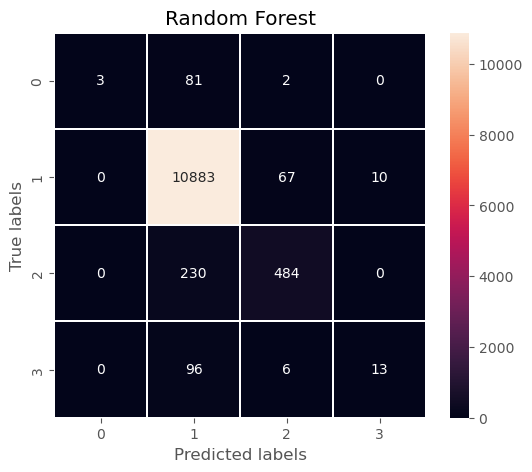

In [58]:
print('ROC Score:')
# print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_tuned))

print('\nConfusion Matrix:')
#plot confusion matrix
confus_matrix_log = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize= (6,5))
ax= plt.subplot()
sns.heatmap(confus_matrix_log , annot=True, fmt='g', ax=ax, linewidth =0.2);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Random Forest'); 

In [59]:
print('Train:', rf_tuned.score(X_train, y_train))
print()
print('Test:', rf_tuned.score(X_test, y_test))

Train: 0.999073625702676

Test: 0.9585684210526316


#### Tuning Decision Tree

In [61]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [10, 17, 20],
    'min_samples_split': [100, 300, 400],
    'min_samples_leaf': [100, 200, 400],
    'criterion': ['gini', 'entropy']
}

# Initialize the model
dt = DecisionTreeClassifier(random_state=1000)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    dt,
    param_grid,
    cv=5,  # Use 5-fold cross-validation
    scoring='f1_micro'  # Use F1 score as the evaluation metric
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 100}


In [63]:
from sklearn.tree import DecisionTreeClassifier
# Initialize the model
dt_tuned = DecisionTreeClassifier(criterion='entropy',
                                 max_depth = 10,
                                 min_samples_leaf=100,
                                 min_samples_split=100,
                                 random_state = 1000)

# Fit the model to the training data
dt_tuned.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=100,
                       min_samples_split=100, random_state=1000)

In [64]:
# Predict the classes on the test data
y_pred_tuned = dt_tuned.predict(X_test.values)
# Predict probabilities
probs = dt_tuned.predict_proba(X_test.values)

c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  
c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  


ROC Score:

Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        86
         2.0       0.95      0.99      0.97     10960
         3.0       0.77      0.55      0.64       714
         4.0       0.00      0.00      0.00       115

    accuracy                           0.95     11875
   macro avg       0.43      0.38      0.40     11875
weighted avg       0.93      0.95      0.94     11875


Confusion Matrix:


c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kagir\anaconda3\envs\matrix\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


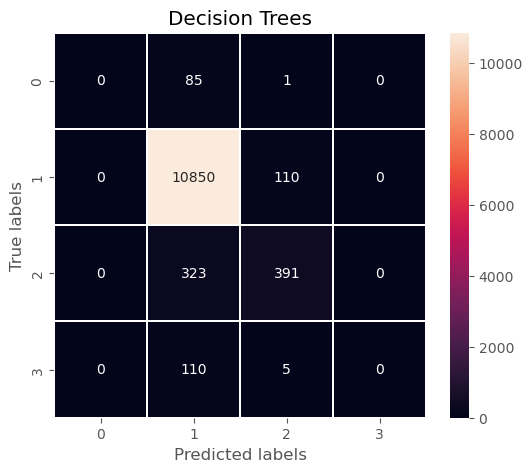

In [66]:
# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
# print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_tuned))

print('\nConfusion Matrix:')
#plot confusion matrix
confus_matrix_log = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize= (6,5))
ax= plt.subplot()
sns.heatmap(confus_matrix_log , annot=True, fmt='g', ax=ax, linewidth =0.2);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Decision Trees'); 

In [67]:
# Training and test accuracy score
print('Train:', dt_tuned.score(X_train, y_train))
print()
print('Test:', dt_tuned.score(X_test, y_test))

Train: 0.9454491862643957

Test: 0.9466105263157895


#### save model

In [79]:
import pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(rf_tuned, f)